## Семинар 7: "Методы оптимизации"

ФИО: Подоприхин Максим Александрович

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
#from sklearn.cross_validation import train_test_split
import torch
from torch import nn
from torch import functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

%matplotlib notebook
#import seaborn


#from mpl_toolkits.mplot3d import Axes3D #делает 3д рисунок

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [42]:
class Optimizer():
    def __init__(self, variables):
        self.variables = variables
        
    def step(self, loss):
        pass
    
class GD(Optimizer):
    def __init__(self, variables, learning_rate):
        super().__init__(variables)
        self.lr = learning_rate
        
    def step(self, J):
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v in self.variables:
                v -= self.lr * v.grad
                
                v.grad.data.zero_()
                
class Momentum(Optimizer):
    def __init__(self, variables, learning_rate, gamma=0.9):
        super().__init__(variables)
        self.lr = learning_rate
        self.g = gamma
        
        self.moments = []        
        for v in self.variables:
            self.moments.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                moment *= self.g
                moment += self.lr * v.grad
                
                v -= moment
                
                v.grad.data.zero_()
                
class NAG(Optimizer):
    def __init__(self, variables, learning_rate, gamma=0.9):
        super().__init__(variables)
        self.lr = learning_rate
        self.g = gamma
        
        self.moments = []        
        for v in self.variables:
            self.moments.append(torch.zeros_like(v.data))
        
    def step(self, J):
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                moment *= self.g                
                v -= moment
        
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                v += moment
                
                moment += self.lr * v.grad
                
                v -= moment
                
                v.grad.data.zero_()
                
class Adagrad(Optimizer):
    def __init__(self, variables, learning_rate, eps=10**-8):
        super().__init__(variables)
        self.lr = learning_rate
        self.eps = eps
        
        self.g_sq = []
        for v in self.variables:
            self.g_sq.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, g_sq in zip(self.variables, self.g_sq):      
                g_sq += v.grad**2
                v -= self.lr / (g_sq + self.eps).sqrt() * v.grad
                
                v.grad.data.zero_()
                
class Adadelta(Optimizer):
    def __init__(self, variables, learning_rate, gamma = 0.1, eps = 10 ** -8):
        super().__init__(variables)
        self.lr = learning_rate
        self.gamma = gamma
        self.eps = eps
        self.E_gt = []
        self.E_vt = []
        self.v_ = []
        for v in self.variables:
            self.E_gt.append(torch.zeros_like(v.data))
            self.E_vt.append(torch.zeros_like(v.data))
            self.v_.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, E_gt, E_vt, v_ in zip(self.variables, self.E_gt, self.E_vt, self.v_):
                E_vt = self.gamma * E_vt + (1 - self.gamma) * v_ ** 2
                E_gt = self.gamma * E_gt + (1 - self.gamma) * v.grad ** 2
                v_ = np.sqrt(E_vt + self.eps) * v.grad / np.sqrt(E_gt + self.eps)
                #v_ = 0.01 * v.grad / np.sqrt(E_gt + self.eps) #RMSProp
                v -= v_
                
                v.grad.data.zero_()
                
class Adam(Optimizer):
    def __init__(self, variables, learning_rate, b1 = 0.9, b2 = 0.999, eps = 10 ** -8):
        super().__init__(variables)
        self.lr = learning_rate
        self.b1 = b1
        self.b2 = b2
        self.eps = eps
        self.mt = []
        self.vt = []
        self.num_of_iter = 0
        for v in self.variables:
            self.mt.append(torch.zeros_like(v.data))
            self.vt.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J()
        loss.backward()
        self.num_of_iter += 1
        with torch.no_grad():
            for v, mt, vt in zip(self.variables, self.mt, self.vt):
                mt = (self.b1 * mt + (1 - self.b1) * v.grad) / (1 - self.b1 ** self.num_of_iter)
                vt = (self.b2 * vt + (1 - self.b2) * v.grad ** 2) / (1 - self.b2 ** self.num_of_iter)
                v -= self.lr / (vt + self.eps).sqrt() * mt
                
                v.grad.data.zero_()

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [32]:
def apply_opt(optim, J, n_iters=1000):    
    points = []

    for i in range(n_iters):
        points.append((X.item(), Y.item(), J().item()))
        optim.step(J)

    points = np.array(points)
    return points

<IPython.core.display.Javascript object>


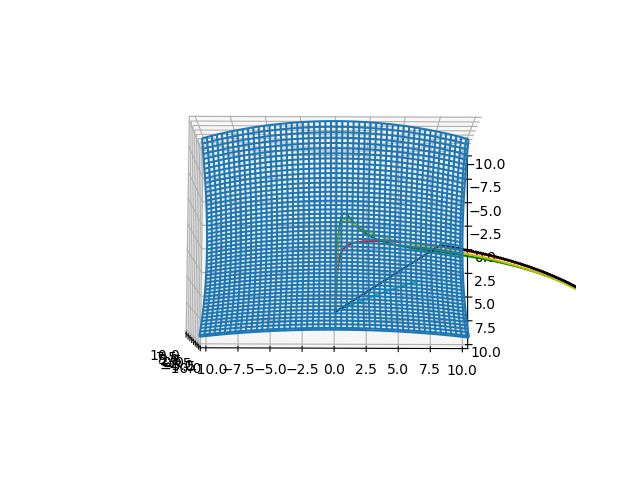

In [8]:
optims = [lambda v: GD(v, 0.1), lambda v: Momentum(v, 0.1),
          lambda v: NAG(v, 0.1), lambda v: Adagrad(v, 0.1), lambda v: Adadelta(v, 0.1), lambda v: Adam(v, 0.1)]

def J(X, Y):
    return X**2 / 10 - Y**2 / 10
    #return X**2/10 * X.sin() - Y**2/10 * Y.cos()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

R = 10
X = np.linspace(-R, R, 100)
Y = np.linspace(-R, R, 100)
ax.set_xlim3d(-R, +R)
ax.set_ylim3d(-R, +R)
ax.set_zlim3d(-R, +R)

xx, yy = np.meshgrid(X, Y)

xx = torch.from_numpy(xx)
yy = torch.from_numpy(yy)

Z = J(xx, yy)

#ax.plot(xx.numpy().flatten(), yy.numpy().flatten(), Z.numpy().flatten())
#ax.plot_surface(xx.numpy(), yy.numpy(), Z.numpy())
ax.plot_wireframe(xx.numpy(), yy.numpy(), Z.numpy())
Colors = ['r', 'g', 'y', 'c', 'm', 'k']
i = 0
for optim in optims:
    #ax = fig.add_subplot(111, projection='3d')
    #ax.plot_wireframe(xx.numpy(), yy.numpy(), Z.numpy())
    X = Variable(torch.tensor(float(8)), requires_grad=True)
    Y = Variable(torch.tensor(float(0.1)), requires_grad=True)
    #print(X)
    #print(Y)
    
    points = apply_opt(optim([X, Y]), lambda X=X, Y=Y: J(X, Y), 500)

    ax.plot(points[:, 0], points[:, 1], points[:, 2], c='{}'.format(Colors[i]))
    i += 1
    #plt.show()
#plt.axis('equal')
plt.show()

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

<IPython.core.display.Javascript object>


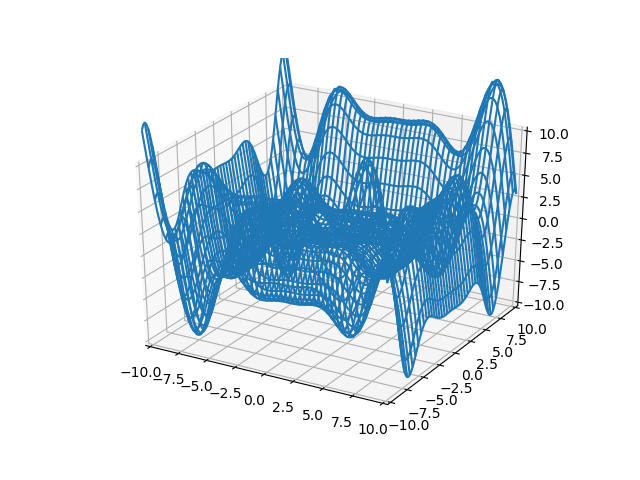

In [9]:
optims = [lambda v: GD(v, 0.1), lambda v: Momentum(v, 0.1),
          lambda v: NAG(v, 0.1), lambda v: Adagrad(v, 0.1), lambda v: Adadelta(v, 0.1), lambda v: Adam(v, 0.1)]

def J(X, Y):
    #return X**2 / 10 - Y**2 / 10
    return X**2/10 * X.sin() - Y**2/10 * Y.cos()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

R = 10
X = np.linspace(-R, R, 100)
Y = np.linspace(-R, R, 100)
ax.set_xlim3d(-R, +R)
ax.set_ylim3d(-R, +R)
ax.set_zlim3d(-R, +R)

xx, yy = np.meshgrid(X, Y)

xx = torch.from_numpy(xx)
yy = torch.from_numpy(yy)

Z = J(xx, yy)

#ax.plot(xx.numpy().flatten(), yy.numpy().flatten(), Z.numpy().flatten())
#ax.plot_surface(xx.numpy(), yy.numpy(), Z.numpy())
ax.plot_wireframe(xx.numpy(), yy.numpy(), Z.numpy())
Colors = ['r', 'g', 'y', 'c', 'm', 'k']
i = 0
for optim in optims:
    #ax = fig.add_subplot(111, projection='3d')
    #ax.plot_wireframe(xx.numpy(), yy.numpy(), Z.numpy())
    X = Variable(torch.tensor(float(8)), requires_grad=True)
    Y = Variable(torch.tensor(float(0.1)), requires_grad=True)
    #print(X)
    #print(Y)
    
    points = apply_opt(optim([X, Y]), lambda X=X, Y=Y: J(X, Y), 500)

    ax.plot(points[:, 0], points[:, 1], points[:, 2], c='{}'.format(Colors[i]))
    i += 1
    plt.show()
#plt.axis('equal')
#plt.show()

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

<IPython.core.display.Javascript object>


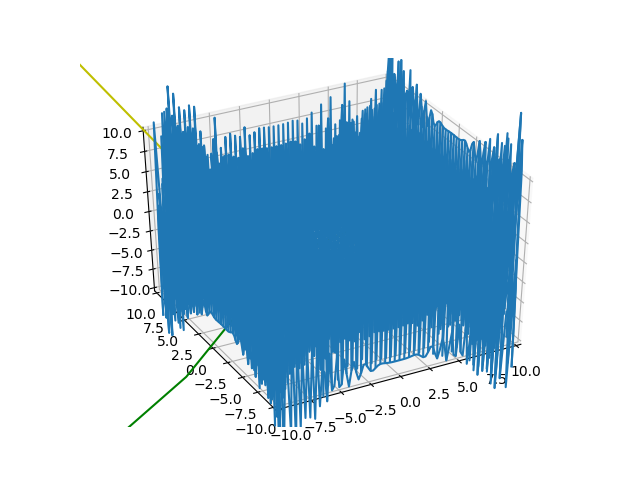

In [10]:
optims = [lambda v: GD(v, 0.1), lambda v: Momentum(v, 0.1),
          lambda v: NAG(v, 0.1), lambda v: Adagrad(v, 0.1), lambda v: Adadelta(v, 0.1), lambda v: Adam(v, 0.1)]

def J(X, Y):
    #return X**2 / 10 - Y**2 / 10
    return X**2/10 * (X ** 2).sin() - Y**2/10 * (Y ** 2).cos()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

R = 10
X = np.linspace(-R, R, 100)
Y = np.linspace(-R, R, 100)
ax.set_xlim3d(-R, +R)
ax.set_ylim3d(-R, +R)
ax.set_zlim3d(-R, +R)

xx, yy = np.meshgrid(X, Y)

xx = torch.from_numpy(xx)
yy = torch.from_numpy(yy)

Z = J(xx, yy)

#ax.plot(xx.numpy().flatten(), yy.numpy().flatten(), Z.numpy().flatten())
#ax.plot_surface(xx.numpy(), yy.numpy(), Z.numpy())
ax.plot_wireframe(xx.numpy(), yy.numpy(), Z.numpy())
Colors = ['r', 'g', 'y', 'c', 'm', 'k']
i = 0
for optim in optims:
    #ax = fig.add_subplot(111, projection='3d')
    #ax.plot_wireframe(xx.numpy(), yy.numpy(), Z.numpy())
    X = Variable(torch.tensor(float(8)), requires_grad=True)
    Y = Variable(torch.tensor(float(0.1)), requires_grad=True)
    #print(X)
    #print(Y)
    
    points = apply_opt(optim([X, Y]), lambda X=X, Y=Y: J(X, Y), 500)

    ax.plot(points[:, 0], points[:, 1], points[:, 2], c='{}'.format(Colors[i]))
    i += 1
    plt.show()
#plt.axis('equal')
#plt.show()

Рассмотрим ф-цию J(x, y) = x^2 + y^2 (рисунок 2D).

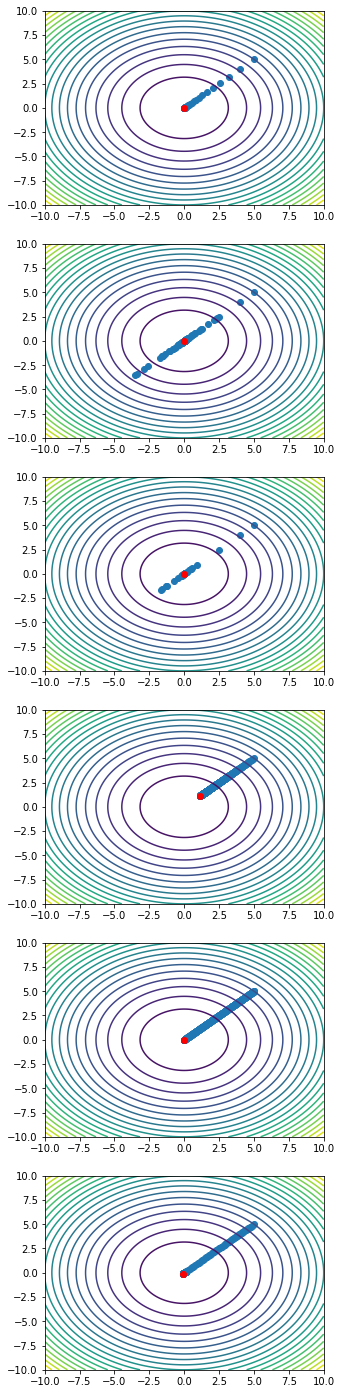

In [43]:
fig, axes = plt.subplots(6, sharex=False, sharey=False)
fig.set_figheight(25)
fig.set_figwidth(5)
optims = [lambda v: GD(v, 0.1), lambda v: Momentum(v, 0.1),
          lambda v: NAG(v, 0.1), lambda v: Adagrad(v, 0.1), lambda v: Adadelta(v, 0.1), lambda v: Adam(v, 0.1)]
def J(X, Y):
    return X**2  + Y**2
check = []
methods = ['GD', 'Momentum', 'NAG', 'Adagrad', 'Adadelta', 'Adam']
for i, optim in enumerate(optims):
    X = Variable(torch.tensor(float(5)), requires_grad=True)
    Y = Variable(torch.tensor(float(5)), requires_grad=True)
    points = apply_opt(optim([X, Y]), lambda X=X, Y=Y: J(X, Y), 500)
    if i == 4:
        check=points
        check = np.asarray(check)
    f = lambda x: J(x[0],x[1])
    x, y = np.meshgrid(np.linspace(-10,10,200), np.linspace(-10,10,200))
    axes[i].contour(x, y, f([x,y]), 20)
    axes[i].scatter(points[:, 0], points[:, 1])
    axes[i].scatter(points[-1, 0], points[-1, 1], c='red')
    #print(points[-1, 0], points[-1, 1])

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize
from tqdm import tqdm

In [3]:
dataset = datasets.MNIST(download=True, train=True, root='./data', transform=Compose([ToTensor()]))
dataloader = DataLoader(dataset, shuffle=True, batch_size=32)
epoch=4

model_linear = nn.Sequential(nn.Linear(28*28, 64), nn.Linear(64, 10), nn.LogSoftmax())
# model_linear
loss_func = nn.NLLLoss()
opt_adam = torch.optim.Adam(model_linear.parameters())
opt_adagrad = torch.optim.Adagrad(model_linear.parameters())
opt_adadelta = torch.optim.Adadelta(model_linear.parameters())
opt_sgd = torch.optim.SGD(model_linear.parameters(), lr=0.01)

In [6]:
def test_opt(opt):
    losses = []
    for e in range(epoch):
        for x, y in dataloader:
            x = torch.FloatTensor(x).view(x.shape[0], -1)
            y = Variable(torch.LongTensor(y))
            y_pred = model_linear(Variable(x))

            loss = loss_func(y_pred, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(np.array(loss.cpu().data))
    return losses

In [7]:
%%time
adam_loss = test_opt(opt_adam)

CPU times: user 3min 14s, sys: 919 ms, total: 3min 15s
Wall time: 1min 9s


In [8]:
%%time
adagrad_loss = test_opt(opt_adagrad)

CPU times: user 2min 11s, sys: 283 ms, total: 2min 11s
Wall time: 44.3 s


In [9]:
%%time
adadelta_loss = test_opt(opt_adadelta)

CPU times: user 2min 40s, sys: 463 ms, total: 2min 41s
Wall time: 55.5 s


In [10]:
%%time
sgd_loss = test_opt(opt_sgd)

CPU times: user 2min 33s, sys: 716 ms, total: 2min 34s
Wall time: 54.7 s


Text(0.5, 1.0, 'SGD')

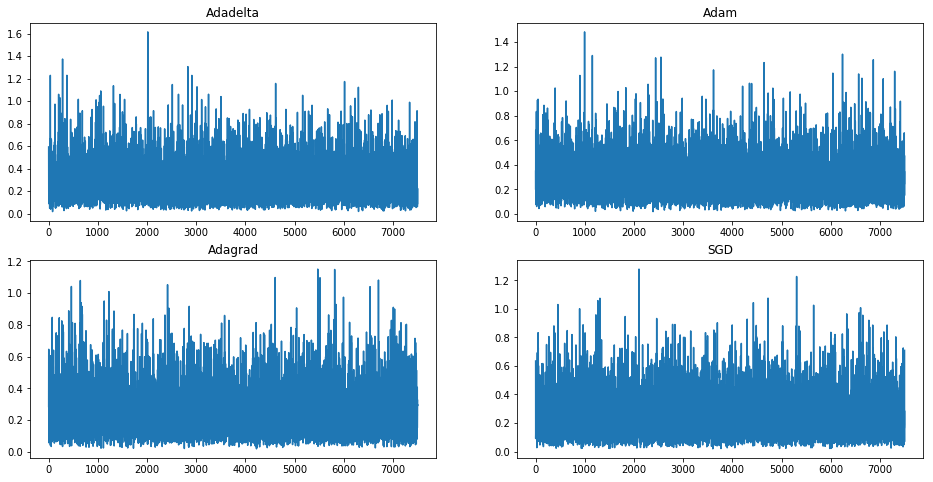

In [14]:
fig = plt.figure(figsize=(16,8))

fig.add_subplot(222)
plt.plot(adam_loss)
plt.title("Adam")

fig.add_subplot(221)
plt.plot(adadelta_loss)
plt.title("Adadelta")

fig.add_subplot(223)
plt.plot(adagrad_loss)
plt.title("Adagrad")

fig.add_subplot(224)
plt.plot(sgd_loss)
plt.title("SGD")

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [15]:
model_conv = nn.Sequential(
    nn.Conv2d(1, 5, 5, bias=True), 
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.ReLU(),
)
model_linear = nn.Sequential(
    nn.Linear(20, 10),
    nn.LogSoftmax(),
)
params = list(model_conv.parameters()) + list(model_linear.parameters())

opt_adam = torch.optim.Adam(params)
opt_adagrad = torch.optim.Adagrad(params)
opt_adadelta = torch.optim.Adadelta(params)
opt_sgd = torch.optim.SGD(params, lr=0.01)

In [16]:
def test_opt(opt):
    losses = []
    for e in range(epoch):
        for x, y in dataloader:
            x = torch.FloatTensor(x).view(x.shape[0], 1, 28, 28)
            y = Variable(torch.LongTensor(y))
            
            x = model_conv(Variable(x))
            y_pred = model_linear(x.view(x.shape[0], -1))

            loss = loss_func(y_pred, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(np.array(loss.cpu().data))
    return losses

In [17]:
%%time
adam_loss = test_opt(opt_adam)

CPU times: user 10min 50s, sys: 7min 51s, total: 18min 42s
Wall time: 5min 1s


In [18]:
%%time
adagrad_loss = test_opt(opt_adagrad)

CPU times: user 10min 26s, sys: 7min 20s, total: 17min 47s
Wall time: 4min 41s


In [20]:
%%time
adadelta_loss = test_opt(opt_adadelta)

CPU times: user 10min 29s, sys: 7min 21s, total: 17min 50s
Wall time: 4min 36s


In [21]:
%%time
sgd_loss = test_opt(opt_sgd)

CPU times: user 10min 29s, sys: 7min 22s, total: 17min 51s
Wall time: 4min 45s


Text(0.5, 1.0, 'SGD')

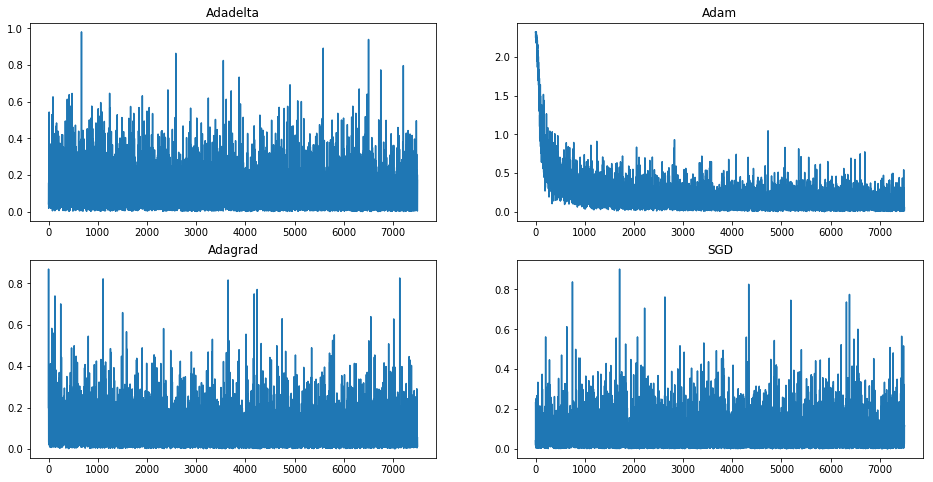

In [22]:
fig = plt.figure(figsize=(16,8))

fig.add_subplot(222)
plt.plot(adam_loss)
plt.title("Adam")

fig.add_subplot(221)
plt.plot(adadelta_loss)
plt.title("Adadelta")

fig.add_subplot(223)
plt.plot(adagrad_loss)
plt.title("Adagrad")

fig.add_subplot(224)
plt.plot(sgd_loss)
plt.title("SGD")

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: